***

## DS195-1 Assignment 3
### Natural Language Processing

**Made by**: Learning Team 2<br>

- CARREON, Ma. Addine Anne T.<br>
- CHAMORRO, Hans Marvin N.<br>
- TABIAN, Luis Carlos P.<br>
- VILLAPANDO, Christian James D.<br>

**Course**: DS195-1_BM9_2T2425<br>
**Instructor**: Madhavi Devaraj

In [1]:
# Library Imports
import os
import fitz
import nltk
import string
import pyLDAvis
import pdfplumber
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

from wordcloud import WordCloud

C:\Users\villa\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\villa\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\villa\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


## Extract Text from PDFs

In [2]:
# Directory containing PDFs
pdf_folder = r"C:\Users\villa\Official-Folder\Data-Science\DS\DS195-1\Assignment 3\Documents"

# Read text from PDFs
def extract_text_from_pdfs(folder_path):
    documents = []
    for file in os.listdir(folder_path):
        if file.endswith(".pdf"):
            with fitz.open(os.path.join(folder_path, file)) as doc:
                text = ""
                for page in doc:
                    text += page.get_text("text") + " "
                documents.append(text.strip())
    return documents

# Extract text
documents = extract_text_from_pdfs(pdf_folder)
print(f"Extracted {len(documents)} documents.")

Extracted 10 documents.


## Data Preprocessing

This code preprocesses text data and applies Latent Dirichlet Allocation (LDA) for topic modeling. It begins by converting text to lowercase, removing punctuation, tokenizing words, and filtering out stopwords and non-alphabetic words. The cleaned text is then transformed into a Bag-of-Words (BoW) representation, where a dictionary maps unique words to numerical IDs, and each document is converted into a BoW format. Using this representation, an LDA model is trained with five topics, iterating over the dataset ten times to refine topic distributions. Finally, the model extracts and displays the top ten words per topic, helping to identify key themes within the collected documents. 

In [3]:
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove stopwords & numbers
    return words

# Apply preprocessing
processed_docs = [preprocess_text(doc) for doc in documents]

In [4]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_docs)

# Convert document into a Bag-of-Words
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model with k=5 topics
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Display the top words for each topic
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.009*"energy" + 0.008*"level" + 0.007*"sti" + 0.006*"panel" + 0.006*"countries" + 0.005*"renewable" + 0.005*"j" + 0.005*"significance" + 0.005*"study" + 0.005*"also"')
(1, '0.015*"cultural" + 0.012*"southeast" + 0.010*"asia" + 0.009*"global" + 0.007*"globalization" + 0.006*"economic" + 0.006*"culture" + 0.006*"asian" + 0.005*"world" + 0.005*"globalisation"')
(2, '0.000*"economic" + 0.000*"southeast" + 0.000*"asian" + 0.000*"energy" + 0.000*"globalization" + 0.000*"growth" + 0.000*"environmental" + 0.000*"al" + 0.000*"development" + 0.000*"et"')
(3, '0.010*"industrial" + 0.010*"singapore" + 0.008*"growth" + 0.008*"economic" + 0.008*"development" + 0.007*"southeast" + 0.007*"asia" + 0.006*"asian" + 0.006*"batam" + 0.006*"policy"')
(4, '0.014*"environmental" + 0.009*"economic" + 0.009*"countries" + 0.008*"al" + 0.008*"et" + 0.008*"globalization" + 0.008*"growth" + 0.007*"energy" + 0.006*"asian" + 0.006*"efficiency"')


This code generates an interactive topic visualization using pyLDAvis. It converts the trained LDA model into a visualization-friendly format with gensimvis.prepare() and then displays it using pyLDAvis.display(). The output shows topics as bubbles, where size indicates prevalence and distance reflects similarity. Clicking a topic reveals its top keywords, helping to interpret and refine the model. 

In [5]:
# Prepare the visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Show visualization
pyLDAvis.display(lda_display)

## Number of Topics for LDA

This code finds the optimal number of topics (k) for LDA topic modeling by evaluating coherence scores for different values of k. It iterates over a range, trains an LDA model for each k, calculates its coherence score, and selects the k with the highest score. The best k is then used to retrain the final LDA model, ensuring a more coherent and interpretable topic distribution. 

In [6]:
def find_best_k(start, end):
    best_k = start
    best_coherence = 0
    for k in range(start, end+1):
        model = LdaModel(corpus, num_topics=k, id2word=dictionary, passes=10)
        coherence_model = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence="c_v")
        coherence_score = coherence_model.get_coherence()
        print(f"Coherence Score for k={k}: {coherence_score}")
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_k = k
    return best_k

# Find the ideal k
ideal_k = find_best_k(2, 10)
print(f"Optimal number of topics: {ideal_k}")

# Rerun LDA with the best k
lda_model = LdaModel(corpus, num_topics=ideal_k, id2word=dictionary, passes=10)

Coherence Score for k=2: 0.3154067063198174
Coherence Score for k=3: 0.4652869549559249
Coherence Score for k=4: 0.4112340239762151
Coherence Score for k=5: 0.4468096154258552
Coherence Score for k=6: 0.4270159593022904
Coherence Score for k=7: 0.452978094225852
Coherence Score for k=8: 0.46512449351739465
Coherence Score for k=9: 0.45412260068479504
Coherence Score for k=10: 0.4437517703160433
Optimal number of topics: 3


## Highest Topic Contributing Documents 

In [7]:
def get_top_documents(lda_model, corpus, documents, top_n=2):
    topic_docs = {i: [] for i in range(lda_model.num_topics)}
    
    for i, doc_bow in enumerate(corpus):
        topic_distribution = lda_model[doc_bow]
        dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
        topic_docs[dominant_topic].append((i, documents[i]))  # Store (doc index, content)
    
    # Get top N documents for each topic
    for topic, docs in topic_docs.items():
        sorted_docs = sorted(docs, key=lambda x: len(x[1]), reverse=True)[:top_n]  # Sort by length (proxy for importance)
        print(f"\n🔹 **Topic {topic} Representative Documents:**")
        for idx, content in sorted_docs:
            print(f"📄 Document {idx+1}: {content[:500]}...\n")  # Print first 500 chars

# Get top documents per topic
get_top_documents(lda_model, corpus, documents)


🔹 **Topic 0 Representative Documents:**
📄 Document 4: Resources Policy 82 (2023) 103556
Available online 14 April 2023
0301-4207/© 2023 Elsevier Ltd. All rights reserved.
Environmental innovations, energy innovations, governance, and 
environmental sustainability: Evidence from South and Southeast 
Asian countries 
Lei Lei a,b, Ilhan Ozturk c,d,e,*, Muntasir Murshed f,g,**, Sirojiddin Abrorov h, Rafael Alvarado i, 
Haider Mahmood j 
a School of Marxism, Southwest University of Science and Technology, Mianyang, 621010, Sichuan, China 
b School of Pu...

📄 Document 3: Renewable Energy 211 (2023) 895–902
Available online 16 March 2023
0960-1481/© 2023 Published by Elsevier Ltd.
Do structural transformation and urbanization assist in enhancing 
sustainable energy technologies innovations? Evidence from 
ASEAN countries 
Jianxing Chen a, Shiwei Wei b,*, Chun Mei a 
a School of Credit Management, Guangdong University of Finance, Guangzhou, Guangdong, PR China 
b School of Economics and Trad

## WordCloud Visualization

C:\Users\villa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\villa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\villa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


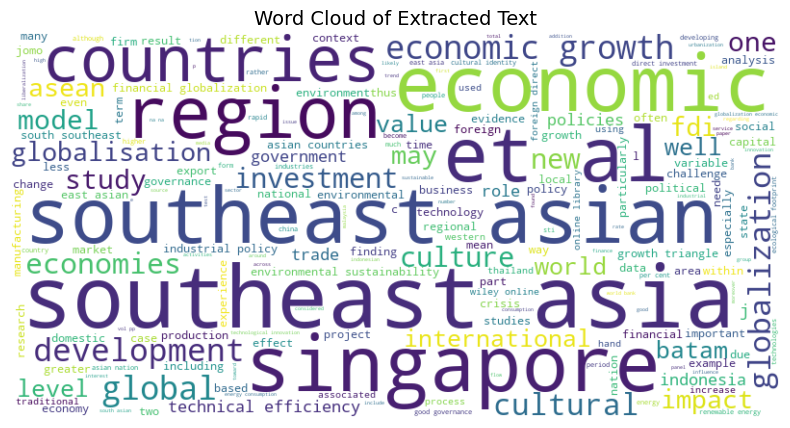

In [8]:
# Combine all processed words into a single string
all_words = " ".join([" ".join(doc) for doc in processed_docs])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_words)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axis
plt.title("Word Cloud of Extracted Text", fontsize=14)
plt.show()

## Document References

Amornkitvikai, Y., & Charoenrat, T. (2024). The impact of female chief executive officers, ownership, and globalization on ASEAN manufacturers' technical efficiency performance. Research in Globalization, 8, 100206.

Celik, A., & Alola, A. A. (2023). Examining the roles of labour standards, economic complexity, and globalization in the biocapacity deficiency of the ASEAN countries. International Journal of Sustainable Development & World Ecology, 30(5), 591-604.

Chen, J., Wei, S., & Mei, C. (2023). Do structural transformation and urbanization assist in enhancing sustainable energy technologies innovations? Evidence from ASEAN countries. Renewable Energy, 211, 895-902.

Chen, J., Zhao, C., Liu, S., & Li, Y. (2025). How do digitalizing ICT and supply chain globalization affect renewable energy in ASEAN nations? The mediating role of sustainable environmental practices using the MMQR and PCSEs model. Energy Economics, 142, 108166.

Doan, T. T. T., & Nguyen, M. L. T. (2024). Managing financial globalization to promote economic growth in the ASEAN-6 countries. Polish Journal of Management Studies, 29(1), 82.

Du, J., Yang, X., Long, D., & Xin, Y. (2024). Modelling the influence of natural resources and social globalization on load capacity factor: New insights from the ASEAN countries. Resources Policy, 91, 104816.

Lei, L., Ozturk, I., Murshed, M., Abrorov, S., Alvarado, R., & Mahmood, H. (2023). Environmental innovations, energy innovations, governance, and environmental sustainability: Evidence from South and Southeast Asian countries. Resources Policy, 82, 103556.

Li, D., Wang, X., Xu, Y., & Ren, Y. (2022). Analysis of export diversification and impact of globalisation on income inequality: evidence from Asian countries. Global Economic Review, 51(3), 195-215.

Nguyen, Q. H. (2024). The influence of key economic globalization factors on economic growth and environmental quality: An empirical study in Southeast Asian countries. The Journal of International Trade & Economic Development, 33(1), 57-75.

Ullah, A. A., & Ming Yit Ho, H. (2021). Globalisation and cultures in Southeast Asia: Demise, fragmentation, transformation. Global Society, 35(2), 191-206.

***